In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/dataset.zip' -d '/content/drive/MyDrive/Colab Notebooks/'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip 'source_path' -d 'output_path'

Import Libraries

In [17]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import pickle
import time
from collections import Counter
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

Custom Graphs

In [ ]:
plt.rcParams.update({'font.size': 12})

Global Variables

In [11]:
IMG_SIZE = 40
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks (1)/dataset/'
CLASSES = sorted([x for x in os.listdir(DATA_DIR) if x != 'fear'])
CLASSES

['angry', 'happy', 'neutral', 'sad', 'surprise']

Preprocessing Function

In [12]:
def preprocess_image(img, output_size=IMG_SIZE, blur_ksize=3):
    
    # resize
    img = cv.resize(img, (output_size, output_size))
    
    # blur
    blur_img = cv.GaussianBlur(img, (blur_ksize,blur_ksize), 0)
    
    # contrast
    contrast = 40
    contrast_img = np.int16(blur_img)
    contrast_img = contrast_img * (contrast/127+1) - contrast
    contrast_img = np.clip(contrast_img, 0, 255)
    contrast_img = np.uint8(contrast_img)
    
    # apply sobel derivatives
    grad_x = cv.Sobel(contrast_img, cv.CV_64F, 1, 0)
    grad_y = cv.Sobel(blur_img, cv.CV_64F, 0, 1)

    # add square and take squareroot 
    grad = np.sqrt(grad_x**2 + grad_y**2)

    # normalize to range 0 to 255 and clip negatives
    output = (grad * 255 / grad.max()).astype(np.uint8)
    
    return output

Apply Preprocessing to Image Dataset

In [19]:
def gen_data(data_dir, categories):                          
    data = []
    
    for category in categories:
        path = data_dir + f'{category}/'
        class_num = categories.index(category)
        
        for file_name in tqdm(os.listdir(path)):
            try:
                img_path = path + file_name
                img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
                    
                output = preprocess_image(img)

                data.append([output, class_num])
                    
            except Exception as e:
                print(e)

    df = pd.DataFrame(data, columns=['image', 'class'])
                
    return df

Save and Read Preprocessed Dataset

In [20]:
# Save
# df.to_pickle('/content/drive/MyDrive/Colab Notebooks (1)/100px_NoFaceDetected.pkl')

df = gen_data(DATA_DIR, CLASSES)

100%|██████████| 7089/7089 [01:35<00:00, 73.97it/s] 


Original vs. Preprocessed 

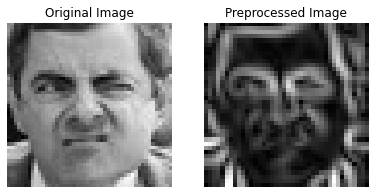

In [22]:
test_img_dir = '/content/drive/MyDrive/Colab Notebooks (1)/test.jpg'
test_img = cv.imread(test_img_dir, cv.IMREAD_GRAYSCALE)
processed_img = preprocess_image(test_img)

plt.figure(figsize=(10, 8))

ax = plt.subplot(1, 3, 1)
ax.axis("off")
plt.imshow(test_img, cmap='gray')
plt.title('Original Image')

ax = plt.subplot(1, 3, 2)
ax.axis("off")
plt.imshow(processed_img, cmap='gray')
plt.title('Preprocessed Image')

plt.show()

Distribution per Emotion

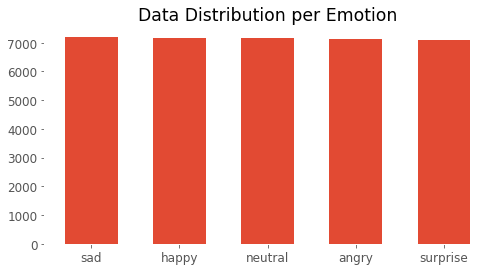

In [ ]:
plt.figure(figsize=(8, 4))
plt.axes().set_facecolor('white')
data = df['class'].value_counts()
data.index = [CLASSES[i] for i in data.index]
plt.bar(x=data.index, height=data, width=0.6)
plt.title('Data Distribution per Emotion')
plt.grid(False)

plt.show()

Visualize Images

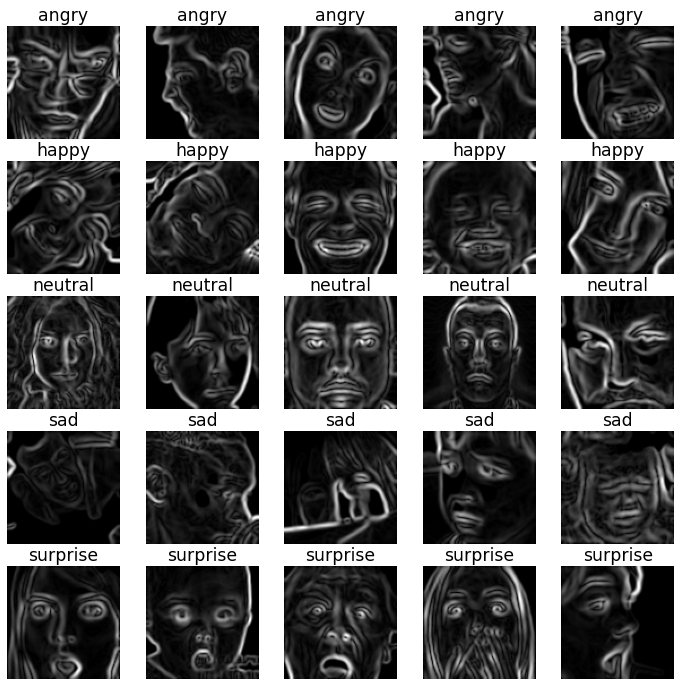

In [ ]:
plt.figure(figsize=(12, 12))

count = 0
for index, cat in enumerate(CLASSES):
      images = train_df.loc[train_df['class'] == index, 'image'].sample(5)
      for img in images:
          count+=1
          ax = plt.subplot(len(CLASSES), 5, count)
          plt.imshow(img, cmap='gray')
          plt.title(cat)
          plt.axis("off")
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/sample_image_81_3')

Split Dataset Train-60, Val-25, Test-15

Train: 21460
Validation: 8941
Test: 5366



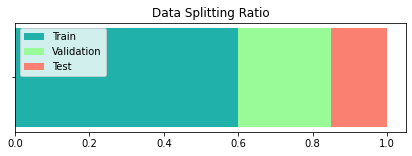

In [23]:
X, y = df['image'], df['class']
train_ratio = 0.60
validation_ratio = 0.25
test_ratio = 0.15

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, shuffle=True, random_state=15)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

x = ['']
print(f'Train: {len(X_train)}')
print(f'Validation: {len(X_val)}')
print(f'Test: {len(X_test)}\n')

fig, ax = plt.subplots(figsize=(7,2))
ax.barh(x, train_ratio, color='lightseagreen', height=0.2)
ax.barh(x, validation_ratio, left=train_ratio, color='palegreen', height=0.2)
ax.barh(x, test_ratio, left=train_ratio+validation_ratio, color='salmon', height=0.2)

ax.legend(["Train", "Validation", "Test"])
ax.set_title("Data Splitting Ratio")


plt.show()

Reshape Image

In [24]:
X_train = np.array([x for x in X_train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array([x for x in y_train]).reshape(-1, 1)

X_val = np.array([x for x in X_val]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array([x for x in y_val]).reshape(-1, 1)

X_test = np.array([x for x in X_test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array([x for x in y_test]).reshape(-1, 1)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (21460, 40, 40, 1)
X_val shape: (8941, 40, 40, 1)
X_test shape: (5366, 40, 40, 1)


Rescale Image

In [25]:
X_train= X_train/255.0
X_val= X_val/255.0
X_test = X_test/255.0

One Hot Encoding of Y values

In [26]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

Data Augmentation Format

In [27]:
datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0)
datagen.fit(X_train)

Model Architecture

In [40]:
def build_model():

    num_classes = len(CLASSES)
    net = Sequential(name='FER_CNN')

    net.add(
        Conv2D(
            filters=32,
            kernel_size=(5,5),
            input_shape=(IMG_SIZE,IMG_SIZE,1),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
        )
    )
    net.add(BatchNormalization())

    net.add(
        Conv2D(
            filters=32,
            kernel_size=(5,5),
            input_shape=(IMG_SIZE,IMG_SIZE,1),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
        )
    )
    net.add(BatchNormalization())
    net.add(MaxPooling2D(pool_size=(2,2)))
    net.add(Dropout(0.4))

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal'
        )
    )
    net.add(BatchNormalization())
    net.add(MaxPooling2D(pool_size=(2,2)))
    net.add(Dropout(0.4))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
        )
    )
    net.add(BatchNormalization())
    net.add(MaxPooling2D(pool_size=(2,2)))
    net.add(Dropout(0.4))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
        )
    )
    net.add(BatchNormalization())
    net.add(MaxPooling2D(pool_size=(2,2)))
    net.add(Dropout(0.4))

    net.add(Flatten())
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
        )
    )
    net.add(BatchNormalization())
    
    net.add(Dropout(0.25))
    
    net.add(
        Dense(
            5,
            activation='softmax',
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return net

In [44]:
model = build_model()
model.summary()

Model: "FER_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 40, 40, 32)        832       
                                                                 
 batch_normalization_26 (Bat  (None, 40, 40, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 40, 40, 32)        25632     
                                                                 
 batch_normalization_27 (Bat  (None, 40, 40, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 20, 20, 32)       0         
 g2D)                                                            
                                                           

Early Stopping to avoid Overfitting

In [45]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

Model Training

In [46]:
batch_size = 64
epochs = 500

history = model.fit(datagen.flow(X_train, 
                    y_train, 
                    batch_size=batch_size),   
                    epochs=epochs, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    shuffle=True)

Epoch 1/500
336/336 [==============================] - 12s 31ms/step - loss: 1.8447 - accuracy: 0.2367 - val_loss: 1.6076 - val_accuracy: 0.2693
Epoch 2/500
336/336 [==============================] - 10s 30ms/step - loss: 1.5988 - accuracy: 0.2821 - val_loss: 1.5514 - val_accuracy: 0.3240
Epoch 3/500
336/336 [==============================] - 11s 33ms/step - loss: 1.5391 - accuracy: 0.3164 - val_loss: 1.5033 - val_accuracy: 0.3498
Epoch 4/500
336/336 [==============================] - 10s 30ms/step - loss: 1.4970 - accuracy: 0.3437 - val_loss: 1.4161 - val_accuracy: 0.4039
Epoch 5/500
336/336 [==============================] - 10s 30ms/step - loss: 1.4676 - accuracy: 0.3666 - val_loss: 1.4078 - val_accuracy: 0.4086
Epoch 6/500
336/336 [==============================] - 10s 30ms/step - loss: 1.4377 - accuracy: 0.3842 - val_loss: 1.3480 - val_accuracy: 0.4416
Epoch 7/500
336/336 [==============================] - 10s 30ms/step - loss: 1.4123 - accuracy: 0.3955 - val_loss: 1.3168 - val_ac

Model Evaluation

In [ ]:
# history = pd.DataFrame(history.history)
history = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/history_77_5_part2.csv')
history.head()

,loss,accuracy,val_loss,val_accuracy
0,1.860235,0.267310,2.350302,0.232275
1,1.553413,0.335849,1.595799,0.390628
2,1.404298,0.415106,1.294107,0.501006
3,1.285626,0.479126,1.172646,0.541601
4,1.189237,0.518405,1.164913,0.558488


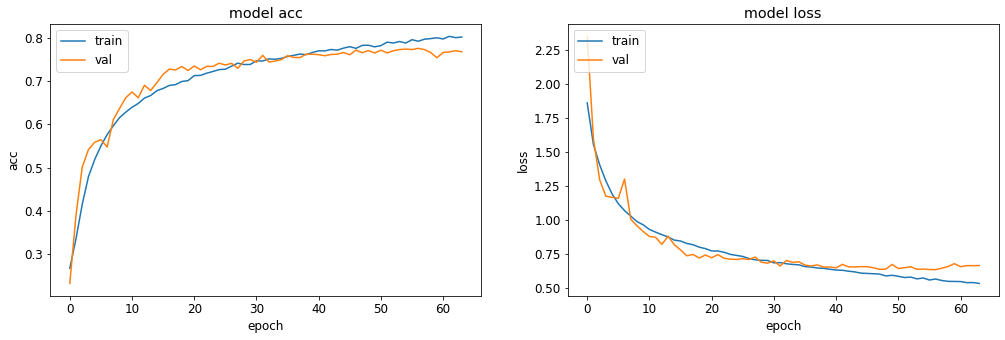

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))

ax1.plot(history['accuracy'])
ax1.plot(history['val_accuracy'])
ax1.set_title('model acc')
ax1.set_ylabel('acc')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history['loss'])
ax2.plot(history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/epoch_history.png')
plt.show()

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/proposed_model.h5')

In [ ]:
predictions = model.predict(X_test)

y_pred_values = []
y_test_values = []

for prediction in predictions:
    y_pred_values.append(prediction.argmax())

for prediction in y_test:
    y_test_values.append(prediction.argmax())  

In [ ]:
print(f'Predictions {y_pred_values[:10]}')
print(f'Actual {y_test_values[:10]}')

Predictions [1, 0, 2, 4, 0, 2, 2, 2, 2, 0]
Actual [3, 0, 2, 4, 0, 2, 4, 2, 2, 0]


In [ ]:
mat = confusion_matrix(y_test_values, y_pred_values)

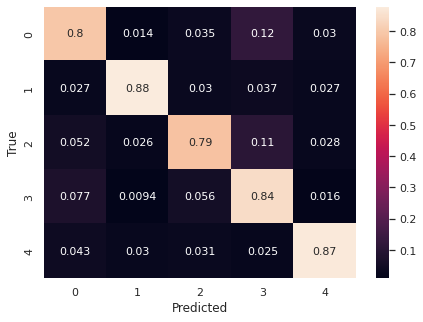

{0: 'angry', 1: 'happy', 2: 'neutral', 3: 'sad', 4: 'surprise'}


In [ ]:
import seaborn as sns

df_cm = pd.DataFrame(mat)
df_cm = df_cm.div(df_cm.sum(axis=1), axis=0)

plt.figure(figsize = (7,5))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 11}, cmap='rocket')
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/confusion_matrix_77_5_part2.png')
plt.show()

print(dict(x for x in enumerate(CLASSES)))

In [ ]:
# model.save_weights('/content/drive/MyDrive/Colab Notebooks (1)/proposed_model.h5')

In [ ]:
print(classification_report(y_test_values, y_pred_values, digits=3, target_names=CLASSES))

              precision    recall  f1-score   support

       angry      0.811     0.782     0.796      1093
       happy      0.917     0.871     0.894      1058
     neutral      0.826     0.771     0.798      1024
         sad      0.738     0.861     0.794      1097
    surprise      0.894     0.875     0.884      1094

    accuracy                          0.833      5366
   macro avg      0.837     0.832     0.833      5366
weighted avg      0.837     0.833     0.833      5366



Model Accuracy

In [ ]:
accuracy_score(y_test_values, y_pred_values)

0.8326500186358554

Tranfer Learning

In [ ]:
import matplotlib.pyplot as plt
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from tqdm import tqdm
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization

In [ ]:
# Load Dataset
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/100px_NoFaceDetected.pkl')

# Remove 'fear' class
df = df[df['class'] != 1].copy()
df['class'] = df['class'].apply(lambda x: x-1 if x > 1 else x)

In [ ]:
IMG_SIZE = 100

# Grayscale to RGB
df['image'] = df['image'].apply(lambda row: cv.cvtColor(row, cv.COLOR_GRAY2BGR))

# Split Dataset
X, y = df['image'], df['class']
train_ratio = 0.60
validation_ratio = 0.25
test_ratio = 0.15

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, shuffle=True, random_state=15)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

x = ['']
print(f'Train: {len(X_train)}')
print(f'Validation: {len(X_val)}')
print(f'Test: {len(X_test)}\n')


# Reshape
X_train = np.array([x for x in X_train]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_train = np.array([x for x in y_train]).reshape(-1, 1)

X_val = np.array([x for x in X_val]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_val = np.array([x for x in y_val]).reshape(-1, 1)

X_test = np.array([x for x in X_test]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_test = np.array([x for x in y_test]).reshape(-1, 1)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')

# One hot encode y values
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

Train: 21462
Validation: 8942
Test: 5366

X_train shape: (21462, 100, 100, 3)
X_val shape: (8942, 100, 100, 3)
X_test shape: (5366, 100, 100, 3)


In [ ]:
train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0)
train_gen.fit(X_train)

val_gen = ImageDataGenerator(rescale=1./255)
val_gen.fit(X_val)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

  ax1.plot(history.history['accuracy'])
  ax1.plot(history.history['val_accuracy'])
  ax1.set_title('model accuracy')
  ax1.set_ylabel('')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'val'], loc='upper left')

  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('model loss')
  ax2.set_ylabel('')
  ax2.set_xlabel('epoch')
  ax2.legend(['train', 'val'], loc='upper left')

  plt.show()

In [ ]:
BATCH_SIZE = 64
EPOCHS = 500

VGG19

In [ ]:
trained_model = VGG19(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False)

# Set All layers to trainable FALSE
for layer in trained_model.layers:
  layer.trainable = False

# Flatten layers
flatten = Flatten()(trained_model.output)

# Prediction
prediction = Dense(5, activation='softmax')(flatten)

# New Model
vgg_model = Model(inputs=trained_model.input, outputs=prediction, name='VGG19')

# Summary
vgg_model.summary()

In [ ]:
# Compile Model
vgg_model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )

In [ ]:
vgg_history = vgg_model.fit(train_gen.flow(X_train, 
                            y_train, 
                            batch_size=BATCH_SIZE),   
                            epochs=EPOCHS, 
                            validation_data=val_gen.flow(X_val, 
                                                           y_val, 
                                                           batch_size=BATCH_SIZE),
                            callbacks=[early_stopping],
                            shuffle=True)

VGG19 Training Result

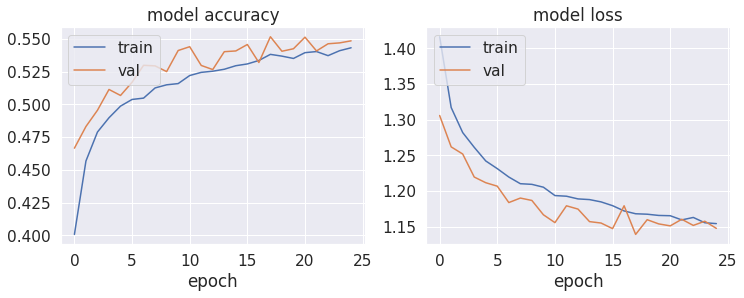

In [ ]:
plot_history(vgg_history)

ResNet50

In [ ]:
trained_model = ResNet50(input_shape=(100, 100, 3), weights='imagenet', include_top=False)

# Set All layers to trainable FALSE
for layer in trained_model.layers:
  layer.trainable = False

# Flatten layers
x = Flatten()(trained_model.output)

# Prediction
prediction = Dense(5, activation='softmax')(x)

# New Model
resnet_model = Model(inputs=trained_model.input, outputs=prediction)

# Summary
resnet_model.summary()

In [ ]:
# Compile Model
resnet_model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )

In [ ]:
resnet_history = resnet_model.fit(train_gen.flow(X_train, 
                                  y_train, 
                                  batch_size=BATCH_SIZE),   
                                  epochs=EPOCHS, 
                                  validation_data=val_gen.flow(X_val, 
                                                               y_val, 
                                                               batch_size=BATCH_SIZE),
                                  callbacks=[early_stopping],
                                  shuffle=True)

ResNet50 Training Result

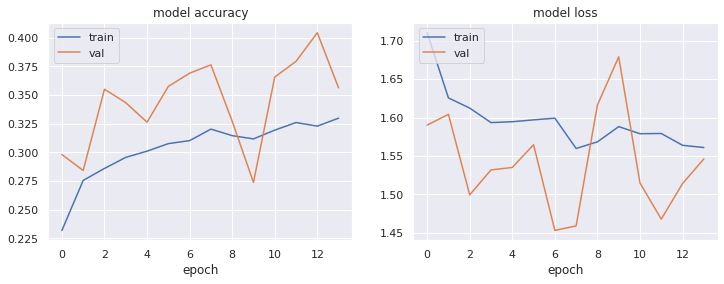

In [ ]:
plot_history(resnet_history)

K Fold Cross Validation of ***Proposed Model***

In [ ]:
# Load Dataset
df = read_data()

In [ ]:
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/log.csv', append=True, separator=',')
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    verbose=1,
    restore_best_weights=True,
)

def train_model(model, X_train, y_train, X_val, y_val):
  history = model.fit(train_gen.flow(X_train, y_train),   
                                  epochs=100,
                                  batch_size=64, 
                                  validation_data=val_gen.flow(X_val, y_val),
                                  callbacks=[early_stopping, csv_logger],
                                  shuffle=True)
  return history

In [ ]:
def plot_history(history, fold):
  fig, axs = plt.subplots(2)
  axs[0].plot(history.history["accuracy"], label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title(f"Fold {fold} Accuracy")

  axs[1].plot(history.history["loss"], label="train error")
  axs[1].plot(history.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title(f"Fold {fold} Loss")

In [ ]:
from sklearn.model_selection import StratifiedKFold

y_test_val = []
y_pred_val = []
fold = 0

kf = StratifiedKFold(5, shuffle=True, random_state=42) 
splits = kf.split(df, df['class'])

# Must specify y StratifiedKFold for
for n, (train_index,test_index) in enumerate(splits):

    # Number of Fold
    fold+=1
    print(f'\n\nTraining on Fold {fold}...\n\n')

    # Split DataFrame
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

    # Train Test
    X_train = np.array(train_df['image'].tolist())
    y_train = np.array(train_df['class'].tolist())
    X_test = np.array(test_df['image'].tolist())
    y_test = np.array(test_df['class'].tolist())

    X_train = np.array([x for x in X_train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    X_test = np.array([x for x in X_test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    # Image Augmentation
    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0)
    train_gen.fit(X_train)

    val_gen = ImageDataGenerator(rescale=1./255)
    val_gen.fit(X_test)

    # CNN Model
    model = None
    model = build_model()

    # Train Model
    history = train_model(model, X_train, y_train, X_test, y_test)

    # Plot Training
    plot_history(history, fold)

    # Model Predictions
    X_test = X_test/255.0
    predictions = model.predict(X_test)

    pred = []
    true = []

    for prediction in predictions:
        pred.append(prediction.argmax())

    for y_val in y_test:
        true.append(y_val.argmax()) 

    # Fold Accuracy
    score = accuracy_score(true, pred)
    print(f"\n\nFold {fold} Accuracy: {score}\n\n")

# Overall accuracy
all_y_test_val = list(np.concatenate(y_test_val).flat)
all_y_pred_val = list(np.concatenate(y_pred_val).flat)
overall_score = accuracy_score(all_y_test_val, all_y_pred_val)
print(f"\n\nFinal Accuracy: {overall_score}")    
    
# Save Predictions to Dataframe
y_test_val_df = pd.DataFrame(y_test_val)
y_pred_val_df = pd.DataFrame(y_pred_val)
model_predictions_df = pd.concat( [y_test_val_df, y_pred_val_df],axis=1 )



Training on Fold 1...


Epoch 1/100
895/895 [==============================] - 98s 108ms/step - loss: 1.7269 - accuracy: 0.2867 - val_loss: 1.3993 - val_accuracy: 0.4146
Epoch 2/100
895/895 [==============================] - 95s 106ms/step - loss: 1.4230 - accuracy: 0.3980 - val_loss: 1.2514 - val_accuracy: 0.5096
Epoch 3/100
895/895 [==============================] - 94s 105ms/step - loss: 1.2332 - accuracy: 0.4992 - val_loss: 1.1238 - val_accuracy: 0.5637
Epoch 4/100
895/895 [==============================] - 94s 105ms/step - loss: 1.1174 - accuracy: 0.5548 - val_loss: 0.9545 - val_accuracy: 0.6276
Epoch 5/100
895/895 [==============================] - 94s 105ms/step - loss: 1.0330 - accuracy: 0.5992 - val_loss: 0.9009 - val_accuracy: 0.6471
Epoch 6/100
895/895 [==============================] - 95s 106ms/step - loss: 0.9781 - accuracy: 0.6217 - val_loss: 0.8541 - val_accuracy: 0.6645
Epoch 7/100
895/895 [==============================] - 95s 106ms/step - loss: 0.9432 - accuracy: 0

In [ ]:
actual

array([0, 0, 0, ..., 4, 4, 4])

In [ ]:
prediction

array([4, 4, 0, ..., 4, 4, 4])

K Fold Cross Validation of ***Benchmark Model***

In [ ]:
# Model Architecture
benchmark_model = Sequential(name='Benchmark_Model')

benchmark_model.add(
    Conv2D(
        filters=32,
        kernel_size=(3,3),
        input_shape=(32, 32, 3),
        activation='relu'
    )
)
benchmark_model.add(MaxPooling2D(pool_size=(2,2)))
benchmark_model.add(Dropout(0.2))

benchmark_model.add(
    Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='relu'
    )
)
benchmark_model.add(MaxPooling2D(pool_size=(2,2)))
benchmark_model.add(Dropout(0.2))

benchmark_model.add(Flatten())
    
benchmark_model.add(
    Dense(
        256,
        activation='relu'
    )
)

benchmark_model.add(
    Dense(
        5,
        activation='softmax'
    )
)

benchmark_model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.01),
        metrics=['accuracy']
    )

benchmark_model.summary()

Model: "Benchmark_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_43 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_61 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 dropout_44 (Dropout)        (None, 6, 6, 32)      